#**Pendahuluan**

**Install Library**

In [1]:
!pip install scaleogram
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import Library**

In [2]:
import string
import argparse as ap
import sys
import os
import numpy as np

import scaleogram as scg 

import obspy
import obspy.core as oc
from obspy import read_inventory
from scipy.signal import welch
# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
from scipy.fftpack import fft

**Load Dataset**

In [3]:
from google.colab import drive
drive.mount("/content/drive")
#Dataset = '/content/drive/My Drive/11_Dataset_Repository/ECGData/ECGData.mat'
events_metaname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_events_10k.csv'
noise_metaname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_noise_1k.csv'

events_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_events_counts_10k.hdf5'
gm_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_events_gm_10k.hdf5'
noise_hdfname='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/HDF5/Instance_noise_1k.hdf5'

eventname = '/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_events_10k.csv'
noisename='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/metadata/metadata_Instance_noise_1k.csv'

%time df_metadata = pd.read_csv(eventname, dtype={'station_location_code': object})

function_plot='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/Def_plot_waveform.py'

plot_seis='/content/drive/My Drive/11_Dataset_Repository/INSTANCE/plot_siesmogram_component.py'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 144 ms, sys: 21.1 ms, total: 166 ms
Wall time: 173 ms


**Read Dataset**

In [4]:
#Metadata Event CSV
events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object},
                             low_memory=False);

#Metadata Event
noise_metaData = pd.read_csv(noise_metaname,dtype={'station_location_code': object}, low_memory=False)

#Metadata Event HDF5
events_h5File = h5py.File(events_hdfname, 'r') # Events in counts
gm_h5File = h5py.File(gm_hdfname, 'r')         # Events in ground motion units
noise_h5File = h5py.File(noise_hdfname, 'r')   # Noise in counts

**Add Internal Function**

In [5]:
import os
os.chdir("/content/drive/My Drive/11_Dataset_Repository/INSTANCE/")
os.chdir("/content/drive/My Drive/11_Dataset_Repository/Function/")

In [6]:
import Def_plot_waveform
from Def_plot_waveform import split, build_stream 

#**Dataset**

**Print Dataset**

In [7]:
events_metaData.head()

,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,station_vs_30_detail,...,trace_sa10_cmps2,trace_sa30_cmps2,trace_name,trace_GPD_P_number,trace_GPD_S_number,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,source_type
0,11030611,IV,OFFI,,HH,42.93500,13.68570,320.0,580.000000,Vs30 extracted from ShakeMap,...,0.001040,9.36700287089e-05,11030611.IV.OFFI..HH,1,2,1.0,1.0,1.0,mps,earthquake
1,11030611,IV,PIEI,,HH,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,...,0.000053,1.49377156134e-05,11030611.IV.PIEI..HH,0,2,1.0,1.0,1.0,mps,earthquake
2,11030611,IV,PIEI,,HN,43.53567,12.53500,665.0,778.339556,Vs30 extracted from ShakeMap,...,0.000239,7.77367705587e-05,11030611.IV.PIEI..HN,2,1,,,,mps2,earthquake
3,11030611,IV,RM33,,EH,42.50898,13.21452,1097.0,721.279254,Vs30 extracted from ShakeMap,...,0.000244,5.49019656038e-05,11030611.IV.RM33..EH,3,7,2.0,2.0,2.0,mps,earthquake
4,11030611,IV,RM33,,HN,42.50898,13.21452,1097.0,721.279254,Vs30 extracted from ShakeMap,...,0.000301,7.51181160727e-05,11030611.IV.RM33..HN,1,3,,,,mps2,earthquake


In [8]:
chosen_lines = []
plots_line = 2
fignumbers = 'abcdefghijklmnopqrstuvwxyz'
alllabs = split(fignumbers)

**Informasi Kejadian Gempa**

In [9]:
cha = 'HH'
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]

print ("Jumlah Kejadian Gempa: ", TOTAL)

df_lbk2 = events_metaData.loc[(events_metaData.source_magnitude < 2) &
                             (events_metaData.station_channels == cha)]
#
lbk2 = df_lbk2.shape[0]
print ("Jumlah Kejadian Gempa (Magnitude < 2) : ", lbk2, "Dengan Persentase : ", round(float(lbk2/TOTAL * 100.),2),"%")
#

df_mag2to3 = events_metaData.loc[(events_metaData.source_magnitude >= 2) &
                             (events_metaData.source_magnitude < 3) & 
                             (events_metaData.station_channels == cha)]

#
mag2to3 = df_mag2to3.shape[0]
print ("Jumlah Kejadian Gempa (2 <= Magnitude < 3) : ", mag2to3, "Dengan Persentase : ", round(float(mag2to3/TOTAL * 100.),2),"%")
#

df_mag3to4 = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.source_magnitude < 4) & 
                             (events_metaData.station_channels == cha)]
#
mag3to4 = df_mag3to4.shape[0]
print ("Jumlah Kejadian Gempa (3 <= Magnitude < 4) : ", mag3to4, "Dengan Persentase : ", round(float(mag3to4/TOTAL * 100.),2),"%")

df_magupto4 = events_metaData.loc[(events_metaData.source_magnitude >= 4) &
                             (events_metaData.station_channels == cha)]
#
magupto4 = df_magupto4.shape[0]
print ("Jumlah Kejadian Gempa (Magnitude >= 4): ", magupto4, "Dengan Persentase : ", round(float(magupto4/TOTAL * 100.),2),"%")
#

if mag2to3 > 0:
    lista = list(df_mag2to3.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
elif mag3to4 > 0:
    lista = list(df_mag3to4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
elif magupto4 > 0:
    lista = list(df_magupto4.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('no waveform found')

Jumlah Kejadian Gempa:  3893
Jumlah Kejadian Gempa (Magnitude < 2) :  749 Dengan Persentase :  19.24 %
Jumlah Kejadian Gempa (2 <= Magnitude < 3) :  2291 Dengan Persentase :  58.85 %
Jumlah Kejadian Gempa (3 <= Magnitude < 4) :  783 Dengan Persentase :  20.11 %
Jumlah Kejadian Gempa (Magnitude >= 4):  70 Dengan Persentase :  1.8 %


#**Analisis FFT**

**FFT Function**

In [10]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

**Plot Komponen E**

In [11]:
chosen_lines = []
plots_line = 2

df_lbk2 = events_metaData.loc[(events_metaData.source_magnitude < 2)]

if lbk2 > 0:
    lista = list(df_lbk2.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines    
else:
    print('')

lines = chosen_lines
# Kind of unit
units = len(lines)*["counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File  

In [12]:
#Fungsi untuk mendapatkan komponan E
def componentE(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max):
    title_size = 24
    labelsize = 24
    legendsize = 20
    label_sec=range(0,60,30)
    formatter = mdates.DateFormatter("%H:%M:%S")

    (fig_width, fig_height) = plt.rcParams['figure.figsize']

    fig_size = [fig_width*2*ncol, fig_height*2*nrow]

    fig = plt.figure(figsize=fig_size)
    outer = gridspec.GridSpec(nrow, ncol, wspace=0.4, hspace=0.4)
    
    irow=3
    for i in range(nrow*ncol):
        inner = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)

        inner1 = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)    
        
        l=lines[i]
        unit=units[i]
        lab=labs[i]
        st,row = build_stream(df,h5,l, wftype, filt, freq_min, freq_max)
        ev_id = row['source_id']
        if wftype != 'noise':
            timeP = row['trace_P_arrival_time']
            timeS = row['trace_S_arrival_time']
        else:
            timeN = row['trace_start_time']

        smax = st.max()
        absmax = max(abs(n) for n in smax)
        yslim = absmax*1.01

        if wftype != 'noise':
            P_date_time_str = timeP
            P_date_time_obj = datetime.datetime.strptime(P_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            S_date_time_str = timeS
            if timeS != "" :
                S_date_time_obj = datetime.datetime.strptime(S_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            N_date_time_str = timeN
            N_date_time_obj = datetime.datetime.strptime(N_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

        custom_lines1 = [Line2D([0], [0], color='k', lw=2),Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        if wftype != 'noise':
            custom_lines2 = [Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        net = st[0].stats.network
        sta = st[0].stats.station
        if wftype != 'noise':
                name = str(ev_id) + '.' + net + '.' + sta +'.'+str(P_date_time_obj.date())
        else:
                name = str(ev_id)

        for j in range(1):
            t_n = 1000
            N = len(st[0].data)
            T = t_n / N
            f_s = 1/T
            #ax = plt.Subplot(fig, inner[j])
            #ax1 = plt.Subplot(fig, inner1[j])
            fig = plt.figure(figsize=(20,5))
            ax = fig.add_subplot(2,2,j+1)
            #fig = plt.figure(figsize=(20,5))
            #ax,ax1 = fig.add_subplot(1,2,1)          
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlim(date2num(st[0].stats.starttime.datetime),date2num(st[0].stats.endtime.datetime))
            ax.xaxis.set_major_locator(mdates.SecondLocator(bysecond=label_sec))
            ax.set_ylim(-yslim,yslim)
            ax.plot(st[0].times("matplotlib"), st[0].data, c='k', lw=1, label = "Trace")
            ax.set_xlabel("Time",fontsize=16)
            ax.set_ylabel("Count",fontsize=16)
            ax.yaxis.set_tick_params(labelleft=True, labelsize=12)
            #f_values, fft_values = get_fft_values(st[0].data, T, N, f_s)
            #ax1.plot(f_values, fft_values, linestyle='-', color='blue')
            #ax1.set_xlabel('Frequency [Hz]', fontsize=16)
            #ax1.set_ylabel('Amplitude', fontsize=16)
            #ax1.set_title("Frequency domain of the signal", fontsize=16)                        
            if wftype != 'noise':
                ax.axvline(date2num(P_date_time_obj), c='indigo', lw=2, label = "Pick_P")
                if timeS != "" :
                    ax.axvline(date2num(S_date_time_obj), c='darkorange', lw=2, label = "Pick_S")
            ax.xaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            ax.set_ylabel(unit,fontsize=labelsize)
            t = ax.yaxis.get_offset_text()
            t.set_size(22)
            if j == 0:
                ch = st[0].stats.channel
                ax.tick_params(labelleft=True, labelbottom=True)
                ax.set_title(name,pad=20,fontsize=title_size)
                ax.text(1, 1.3, lab, transform=ax.transAxes, fontsize=labelsize,ha='right',va='top')
                ax.legend(custom_lines1,[ch],fontsize=legendsize,bbox_to_anchor=(0.99, 0.96), loc=1, borderaxespad=0.,shadow=True)
                ax.set_xlim(date2num(st[0].stats.starttime.datetime),date2num(st[0].stats.endtime.datetime))
                
                ax1 = fig.add_subplot(2,2,j+2)
                f_values, fft_values = get_fft_values(st[0].data, T, N, f_s)
                #fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
                ax1.plot(f_values, fft_values, linestyle='-', color='blue')
                ax1.set_xlabel('Frequency [Hz]', fontsize=16)
                ax1.set_ylabel('Amplitude', fontsize=16)
                ax1.set_title("Frequency domain of the signal", fontsize=16)  
            #plt.tight_layout()
            plt.show()
            #fig.add_subplot(ax)            
#            fig.add_subplot(ax1)            
    fig.show()

<Figure size 1728x576 with 0 Axes>

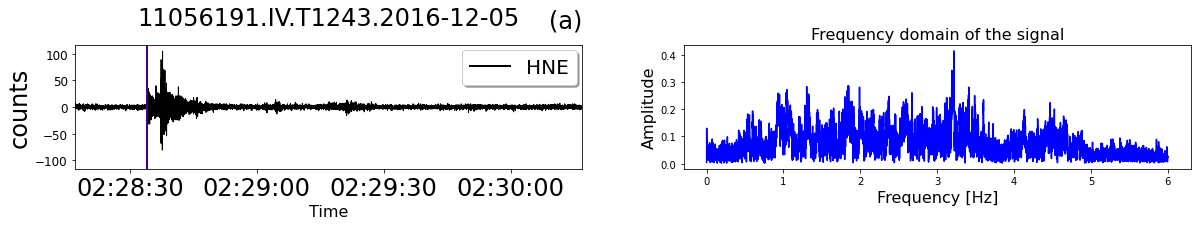

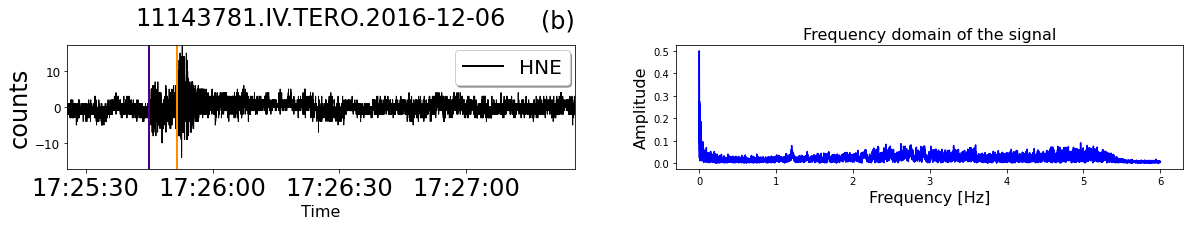

In [13]:
#Seismic signal waveform and frequency distribution - E Component
componentE(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

**Plot Komponen N**

In [14]:
#Fungsi untuk mendapatkan komponan N
def componentN(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max):
    title_size = 24
    labelsize = 24
    legendsize = 20
    label_sec=range(0,60,30)
    formatter = mdates.DateFormatter("%H:%M:%S")

    (fig_width, fig_height) = plt.rcParams['figure.figsize']

    fig_size = [fig_width*2*ncol, fig_height*2*nrow]

    fig = plt.figure(figsize=fig_size)
    outer = gridspec.GridSpec(nrow, ncol, wspace=0.4, hspace=0.4)
    
    irow=3
    for i in range(nrow*ncol):
        inner = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)

        inner1 = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)    
        
        l=lines[i]
        unit=units[i]
        lab=labs[i]
        st,row = build_stream(df,h5,l, wftype, filt, freq_min, freq_max)
        ev_id = row['source_id']
        if wftype != 'noise':
            timeP = row['trace_P_arrival_time']
            timeS = row['trace_S_arrival_time']
        else:
            timeN = row['trace_start_time']

        smax = st.max()
        absmax = max(abs(n) for n in smax)
        yslim = absmax*1.01

        if wftype != 'noise':
            P_date_time_str = timeP
            P_date_time_obj = datetime.datetime.strptime(P_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            S_date_time_str = timeS
            if timeS != "" :
                S_date_time_obj = datetime.datetime.strptime(S_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            N_date_time_str = timeN
            N_date_time_obj = datetime.datetime.strptime(N_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

        custom_lines1 = [Line2D([0], [0], color='k', lw=2),Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        if wftype != 'noise':
            custom_lines2 = [Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        net = st[1].stats.network
        sta = st[1].stats.station
        if wftype != 'noise':
                name = str(ev_id) + '.' + net + '.' + sta +'.'+str(P_date_time_obj.date())
        else:
                name = str(ev_id)

        for j in range(1):
            t_n = 1000
            N = len(st[1].data)
            T = t_n / N
            f_s = 1/T
            #ax = plt.Subplot(fig, inner[j])
            #ax1 = plt.Subplot(fig, inner1[j])
            fig = plt.figure(figsize=(20,5))
            ax = fig.add_subplot(2,2,j+1)
            #fig = plt.figure(figsize=(20,5))
            #ax,ax1 = fig.add_subplot(1,2,1)          
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlim(date2num(st[1].stats.starttime.datetime),date2num(st[1].stats.endtime.datetime))
            ax.xaxis.set_major_locator(mdates.SecondLocator(bysecond=label_sec))
            ax.set_ylim(-yslim,yslim)
            ax.plot(st[1].times("matplotlib"), st[1].data, c='k', lw=1, label = "Trace")
            ax.set_xlabel("Time",fontsize=16)
            ax.set_ylabel("Count",fontsize=16)
            ax.yaxis.set_tick_params(labelleft=True, labelsize=12)
            #f_values, fft_values = get_fft_values(st[0].data, T, N, f_s)
            #ax1.plot(f_values, fft_values, linestyle='-', color='blue')
            #ax1.set_xlabel('Frequency [Hz]', fontsize=16)
            #ax1.set_ylabel('Amplitude', fontsize=16)
            #ax1.set_title("Frequency domain of the signal", fontsize=16)                        
            if wftype != 'noise':
                ax.axvline(date2num(P_date_time_obj), c='indigo', lw=2, label = "Pick_P")
                if timeS != "" :
                    ax.axvline(date2num(S_date_time_obj), c='darkorange', lw=2, label = "Pick_S")
            ax.xaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            ax.set_ylabel(unit,fontsize=labelsize)
            t = ax.yaxis.get_offset_text()
            t.set_size(22)
            if j == 0:
                ch = st[1].stats.channel
                ax.tick_params(labelleft=True, labelbottom=True)
                ax.set_title(name,pad=20,fontsize=title_size)
                ax.text(1, 1.3, lab, transform=ax.transAxes, fontsize=labelsize,ha='right',va='top')
                ax.legend(custom_lines1,[ch],fontsize=legendsize,bbox_to_anchor=(0.99, 0.96), loc=1, borderaxespad=0.,shadow=True)
                ax.set_xlim(date2num(st[1].stats.starttime.datetime),date2num(st[1].stats.endtime.datetime))
                
                ax1 = fig.add_subplot(2,2,j+2)
                f_values, fft_values = get_fft_values(st[1].data, T, N, f_s)
                #fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
                ax1.plot(f_values, fft_values, linestyle='-', color='blue')
                ax1.set_xlabel('Frequency [Hz]', fontsize=16)
                ax1.set_ylabel('Amplitude', fontsize=16)
                ax1.set_title("Frequency domain of the signal", fontsize=16)  
            #plt.tight_layout()
            plt.show()
            #fig.add_subplot(ax)            
#            fig.add_subplot(ax1)            
    fig.show()

<Figure size 1728x576 with 0 Axes>

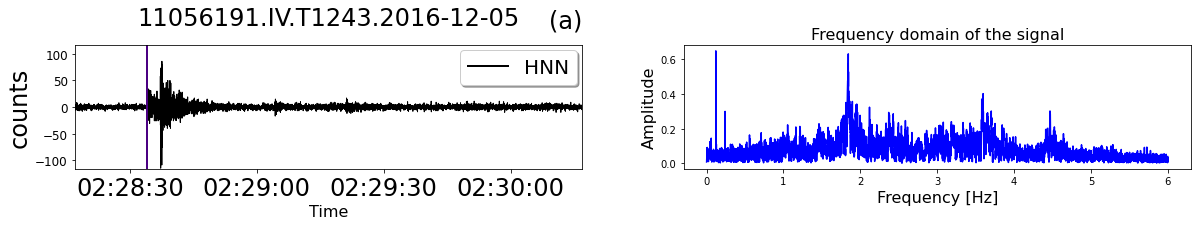

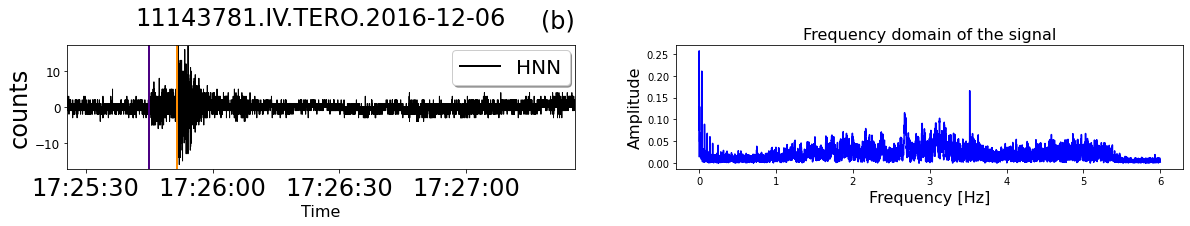

In [15]:
#Seismic signal waveform and frequency distribution - N Component
componentN(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

**Plot Komponen Z**

In [16]:
#Fungsi untuk mendapatkan komponan Z
def componentZ(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max):
    title_size = 24
    labelsize = 24
    legendsize = 20
    label_sec=range(0,60,30)
    formatter = mdates.DateFormatter("%H:%M:%S")

    (fig_width, fig_height) = plt.rcParams['figure.figsize']

    fig_size = [fig_width*2*ncol, fig_height*2*nrow]

    fig = plt.figure(figsize=fig_size)
    outer = gridspec.GridSpec(nrow, ncol, wspace=0.4, hspace=0.4)
    
    irow=3
    for i in range(nrow*ncol):
        inner = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)

        inner1 = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)    
        
        l=lines[i]
        unit=units[i]
        lab=labs[i]
        st,row = build_stream(df,h5,l, wftype, filt, freq_min, freq_max)
        ev_id = row['source_id']
        if wftype != 'noise':
            timeP = row['trace_P_arrival_time']
            timeS = row['trace_S_arrival_time']
        else:
            timeN = row['trace_start_time']

        smax = st.max()
        absmax = max(abs(n) for n in smax)
        yslim = absmax*1.01

        if wftype != 'noise':
            P_date_time_str = timeP
            P_date_time_obj = datetime.datetime.strptime(P_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            S_date_time_str = timeS
            if timeS != "" :
                S_date_time_obj = datetime.datetime.strptime(S_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            N_date_time_str = timeN
            N_date_time_obj = datetime.datetime.strptime(N_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

        custom_lines1 = [Line2D([0], [0], color='k', lw=2),Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        if wftype != 'noise':
            custom_lines2 = [Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        net = st[2].stats.network
        sta = st[2].stats.station
        if wftype != 'noise':
                name = str(ev_id) + '.' + net + '.' + sta +'.'+str(P_date_time_obj.date())
        else:
                name = str(ev_id)

        for j in range(1):
            t_n = 1000
            N = len(st[2].data)
            T = t_n / N
            f_s = 1/T
            #ax = plt.Subplot(fig, inner[j])
            #ax1 = plt.Subplot(fig, inner1[j])
            fig = plt.figure(figsize=(20,5))
            ax = fig.add_subplot(2,2,j+1)
            #fig = plt.figure(figsize=(20,5))
            #ax,ax1 = fig.add_subplot(1,2,1)          
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlim(date2num(st[2].stats.starttime.datetime),date2num(st[2].stats.endtime.datetime))
            ax.xaxis.set_major_locator(mdates.SecondLocator(bysecond=label_sec))
            ax.set_ylim(-yslim,yslim)
            ax.plot(st[2].times("matplotlib"), st[2].data, c='k', lw=1, label = "Trace")
            ax.set_xlabel("Time",fontsize=16)
            ax.set_ylabel("Count",fontsize=16)
            ax.yaxis.set_tick_params(labelleft=True, labelsize=12)
            #f_values, fft_values = get_fft_values(st[0].data, T, N, f_s)
            #ax1.plot(f_values, fft_values, linestyle='-', color='blue')
            #ax1.set_xlabel('Frequency [Hz]', fontsize=16)
            #ax1.set_ylabel('Amplitude', fontsize=16)
            #ax1.set_title("Frequency domain of the signal", fontsize=16)                        
            if wftype != 'noise':
                ax.axvline(date2num(P_date_time_obj), c='indigo', lw=2, label = "Pick_P")
                if timeS != "" :
                    ax.axvline(date2num(S_date_time_obj), c='darkorange', lw=2, label = "Pick_S")
            ax.xaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            ax.set_ylabel(unit,fontsize=labelsize)
            t = ax.yaxis.get_offset_text()
            t.set_size(22)
            if j == 0:
                ch = st[2].stats.channel
                ax.tick_params(labelleft=True, labelbottom=True)
                ax.set_title(name,pad=20,fontsize=title_size)
                ax.text(1, 1.3, lab, transform=ax.transAxes, fontsize=labelsize,ha='right',va='top')
                ax.legend(custom_lines1,[ch],fontsize=legendsize,bbox_to_anchor=(0.99, 0.96), loc=1, borderaxespad=0.,shadow=True)
                ax.set_xlim(date2num(st[2].stats.starttime.datetime),date2num(st[2].stats.endtime.datetime))
                
                ax1 = fig.add_subplot(2,2,j+2)
                f_values, fft_values = get_fft_values(st[2].data, T, N, f_s)
                #fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
                ax1.plot(f_values, fft_values, linestyle='-', color='blue')
                ax1.set_xlabel('Frequency [Hz]', fontsize=16)
                ax1.set_ylabel('Amplitude', fontsize=16)
                ax1.set_title("Frequency domain of the signal", fontsize=16)  
            #plt.tight_layout()
            plt.show()
            #fig.add_subplot(ax)            
#            fig.add_subplot(ax1)            
    fig.show()

<Figure size 1728x576 with 0 Axes>

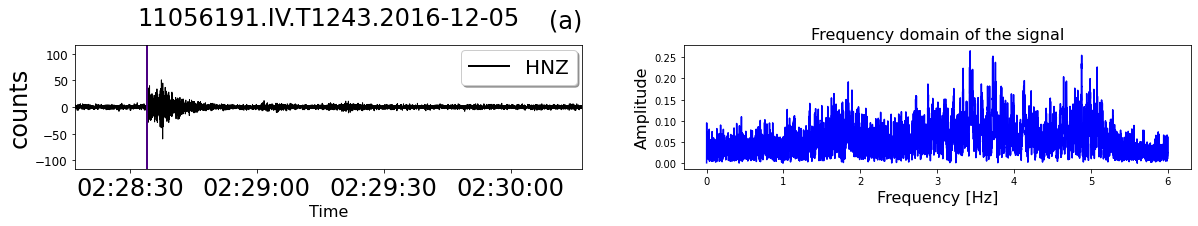

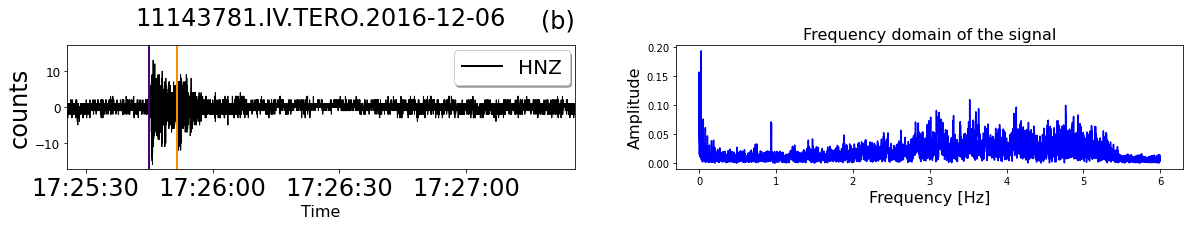

In [17]:
#Seismic signal waveform and frequency distribution - Z Component
componentZ(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

#**Analisis PSD**

In [23]:
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

In [28]:
def componentE(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max):
    title_size = 24
    labelsize = 24
    legendsize = 20
    label_sec=range(0,60,30)
    formatter = mdates.DateFormatter("%H:%M:%S")

    (fig_width, fig_height) = plt.rcParams['figure.figsize']

    fig_size = [fig_width*2*ncol, fig_height*2*nrow]

    fig = plt.figure(figsize=fig_size)
    outer = gridspec.GridSpec(nrow, ncol, wspace=0.4, hspace=0.4)
    
    irow=3
    for i in range(nrow*ncol):
        inner = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)

        inner1 = gridspec.GridSpecFromSubplotSpec(irow, 1,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)    
        
        l=lines[i]
        unit=units[i]
        lab=labs[i]
        st,row = build_stream(df,h5,l, wftype, filt, freq_min, freq_max)
        ev_id = row['source_id']
        if wftype != 'noise':
            timeP = row['trace_P_arrival_time']
            timeS = row['trace_S_arrival_time']
        else:
            timeN = row['trace_start_time']

        smax = st.max()
        absmax = max(abs(n) for n in smax)
        yslim = absmax*1.01

        if wftype != 'noise':
            P_date_time_str = timeP
            P_date_time_obj = datetime.datetime.strptime(P_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            S_date_time_str = timeS
            if timeS != "" :
                S_date_time_obj = datetime.datetime.strptime(S_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            N_date_time_str = timeN
            N_date_time_obj = datetime.datetime.strptime(N_date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

        custom_lines1 = [Line2D([0], [0], color='k', lw=2),Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        if wftype != 'noise':
            custom_lines2 = [Line2D([0], [0], color='indigo', lw=2),Line2D([0], [0], color='darkorange', lw=2)]
        net = st[0].stats.network
        sta = st[0].stats.station
        if wftype != 'noise':
                name = str(ev_id) + '.' + net + '.' + sta +'.'+str(P_date_time_obj.date())
        else:
                name = str(ev_id)

        for j in range(1):
            t_n = 1000
            N = len(st[0].data)
            T = t_n / N
            f_s = 1/T
            #ax = plt.Subplot(fig, inner[j])
            #ax1 = plt.Subplot(fig, inner1[j])
            fig = plt.figure(figsize=(20,5))
            ax = fig.add_subplot(2,2,j+1)
            #fig = plt.figure(figsize=(20,5))
            #ax,ax1 = fig.add_subplot(1,2,1)          
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlim(date2num(st[0].stats.starttime.datetime),date2num(st[0].stats.endtime.datetime))
            ax.xaxis.set_major_locator(mdates.SecondLocator(bysecond=label_sec))
            ax.set_ylim(-yslim,yslim)
            ax.plot(st[0].times("matplotlib"), st[0].data, c='k', lw=1, label = "Trace")
            ax.set_xlabel("Time",fontsize=16)
            ax.set_ylabel("Count",fontsize=16)
            ax.yaxis.set_tick_params(labelleft=True, labelsize=12)                      
            if wftype != 'noise':
                ax.axvline(date2num(P_date_time_obj), c='indigo', lw=2, label = "Pick_P")
                if timeS != "" :
                    ax.axvline(date2num(S_date_time_obj), c='darkorange', lw=2, label = "Pick_S")
            ax.xaxis.set_tick_params(labelleft=True, labelsize=labelsize)
            ax.set_ylabel(unit,fontsize=labelsize)
            t = ax.yaxis.get_offset_text()
            t.set_size(22)
            if j == 0:
                ch = st[0].stats.channel
                ax.tick_params(labelleft=True, labelbottom=True)
                ax.set_title(name,pad=20,fontsize=title_size)
                ax.text(1, 1.3, lab, transform=ax.transAxes, fontsize=labelsize,ha='right',va='top')
                ax.legend(custom_lines1,[ch],fontsize=legendsize,bbox_to_anchor=(0.99, 0.96), loc=1, borderaxespad=0.,shadow=True)
                ax.set_xlim(date2num(st[0].stats.starttime.datetime),date2num(st[0].stats.endtime.datetime))
                
                ax1 = fig.add_subplot(2,2,j+2)
                f_values, psd_values = get_psd_values(st[0].data, T, N, f_s)              
                ax1.plot(f_values, psd_values, linestyle='-', color='blue')
                ax1.set_xlabel('Frequency [Hz]')
                ax1.set_ylabel('PSD [V**2 / Hz]')
                ax1.set_title("Frequency domain of the signal", fontsize=16)  
            plt.show()
    fig.show()

<Figure size 1728x576 with 0 Axes>

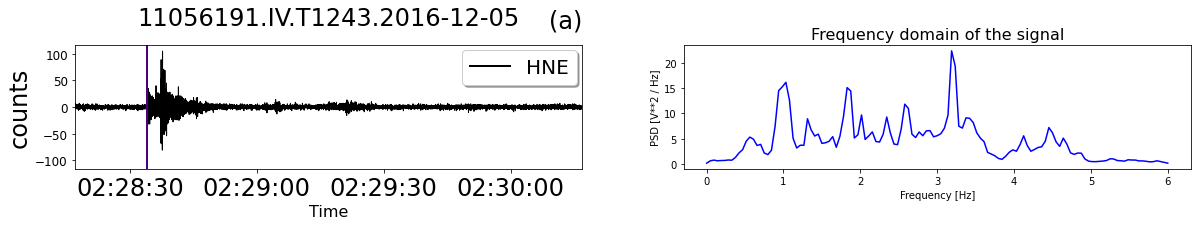

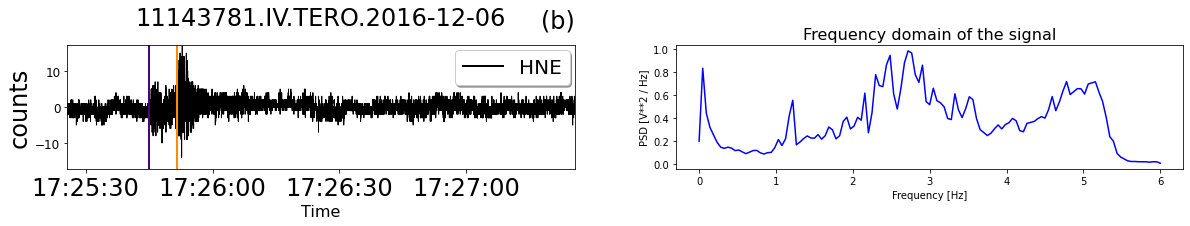

In [29]:
componentE(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)